**DESCRIPTION:** This model will run a regression on all of the data by the identifier(s) specified by the user. The regression is completed using SKLearn which utilizes test and training data to fit a learned model to the data.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

**Calculating the Model:** Creates a function which take a list of identifiers and creates a model for each.

In [2]:
def individual_idents(lst):

    for iden in lst:

        df = df2
        df = df.loc[df['identifier'] == iden]

        # Sets the index of the graph as the date so that the regression occurs
        # over the dates
        df.set_index(pd.DatetimeIndex(df['date']), inplace=True)

        # Sets the  predictor values
        predictors = ['market_cap',	'sector', 'index_membership', 'factor_1',
                  'factor_2', 'factor_3', 'factor_4', 'factor_5', 'factor_6',
                  'factor_7', 'factor_8', 'factor_9', 'factor_10']

        # Uses the train_test_split to randomly select 30% of the data as
        # testing data and saving the rest for the creation/training of the
        # model
        train, test = train_test_split(df, test_size=0.3)

        # Defines the model as a Linear Regression
        model = LinearRegression()

        # Fits the model using the predictors above and defined target
        # training data
        model.fit(train[predictors], train["target"])

        # Creates the predictors using the model.predict
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)

        # Calculates the r^2 score based on the test values and the predicted
        # values
        r = r2_score(test["target"], preds)
        combined = pd.concat({"target": test["target"],"Predictions": preds}, axis=1)
        combined.plot()
        plt.title(iden + " with r^2: " + str(r))

        print("r2 of " + iden + " =" + str(r))

        y = df['target']
        X = df[['market_cap', 'sector', 'index_membership', 'factor_1',
                'factor_2', 'factor_3', 'factor_4', 'factor_5', 'factor_6',
                'factor_7', 'factor_8', 'factor_9', 'factor_10']]

        cv = KFold(n_splits=10, random_state=1, shuffle=True)

        scores = cross_val_score(LinearRegression(), train[predictors], train["target"],
                                 scoring='neg_mean_absolute_error',
                                 cv=cv, n_jobs=-1)

        # the lower the RMSE the better
        print('root mean squared error (RMSE) = ' + str(
            np.sqrt(np.mean(np.absolute(
                scores)))))
        
        plt.show()
        
        print("Now we will perform Hyperparameter Tuning. Based on the accuracy of the original model this may not impact the r^2. \n")
        
        Tuning(test, train, predictors, model, preds)

**Hyperparameter Tuning:** This uses Grid Search Cross-Validation to allow you to attempt to reach the optimal regression results.

In [3]:
        # Hyperparameter Tuning using Grid Search Cross-Validation
        # This allows you to test different numbers of features in the 
        # regression to produce optimal results

def Tuning(test, train, predictors, model, preds):

    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

    hyper_params = [{'n_features_to_select': list(range(1, len(predictors)))}]

    rfe = RFE(model)

    model_cv = GridSearchCV(estimator = rfe, 
                    param_grid = hyper_params, 
                    scoring= 'r2', 
                    cv = folds, 
                    verbose = 1,
                    return_train_score=True)      

    model_cv.fit(train[predictors], train["target"])

    plt.figure(figsize=(16,6))

    cv_results = pd.DataFrame(model_cv.cv_results_)

    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
    plt.xticks(np.arange(0, 14, 2.0))
    plt.xlabel('number of features')
    plt.ylabel('r-squared')
    plt.title("Optimal Number of Features")
    plt.legend(['test score', 'train score'], loc='upper left')

    plt.show()
    
    n_features_optimal = int(input("Select a number that looks as though it will produce the optimal regression based on the above graph. \n"))

    
    lm = LinearRegression()
    lm.fit(train[predictors], train['target'])

    rfe = RFE(lm, n_features_to_select=n_features_optimal)             
    rfe = rfe.fit(train[predictors], train['target'])

    # predict prices of X_test
    y_pred = lm.predict(test[predictors])
    r2_again = r2_score(test["target"], preds)
    print("\n Resulting r^2 is = " + str(r2_again))


**Note on Path to File:** Below I have specified the path to the given CSV containing the data. You do not need to change the path for it to work on this notebook, but if you would like to download the code, you may.

What identifier would you like to model? (i.e. KM943MN5D7E3) 
KM943MN5D7E3
Would you like to add another? - answer 'Y' for yes and 'N' for no 
N
r2 of KM943MN5D7E3 =0.9327668047656361
root mean squared error (RMSE) = 0.044497274428908676


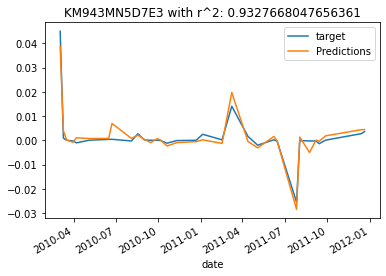

Now we will perform Hyperparameter Tuning. Based on the accuracy of the original model this may not impact the r^2. 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


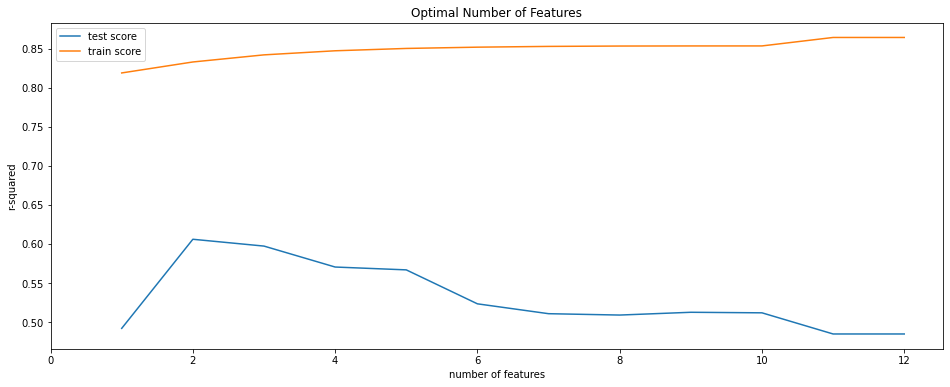

Select a number that looks as though it will produce the optimal regression based on the above graph. 
11

 Resulting r^2 is = 0.9327668047656361


In [4]:
path_to_file = "data/data.csv"

# Reads the information contained in the CSV
df2 = pd.read_csv(path_to_file)

# Prepares a list to hold the identifiers
idents = []

identifier_set = set(df2["identifier"].values.tolist())

# While loop that will continue to ask the user for input until they answer 
# "N". Each identifier that is added is checked to determine if it is valid.
answer = 'Y'
while (answer == 'Y'):
    n = input("What identifier would you like to model? (i.e. KM943MN5D7E3) \n")
    if(n in identifier_set):
        idents.append(n)
        answer = input(
        "Would you like to add another? - answer 'Y' for yes and "
        "'N' for no \n")
    else:
        answer = input("Your input is not an identifier. Would you like to try again? - answer 'Y' for yes and "
        "'N' for no \n")


# Runs the model on the given identifiers
individual_idents(idents)